In [1]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os
import torchvision.transforms as T
import csv
import cv2 as cv
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [2]:
def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    file = pd.read_csv(r'datalabel.csv')
    file=np.array(file)
    labels=[]
    train_data = []
    for file_name in os.listdir(dir):
        if file_name != "Thumbs.db":
            img_dir = os.path.join(dir, file_name)
            img = cv.imread(img_dir)
            #img = cv.resize(img, (769, 432))   # /5 resize img
            #img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
            pimg = Image.fromarray(img)
            train_data.append(pimg)

            for item in file:       #add label
                sh= item[1]
                if file_name == sh:
                    labels.append(item[0])
    labels = torch.tensor(labels)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return train_data,labels

In [3]:
traindir= './train/'
validdir='./valid/'
train_data, train_label = generate_dataset(traindir)
valid_data, valid_label = generate_dataset(validdir)

In [ ]:
print(valid_label)

tensor([[ 89.0880],
        [104.6530],
        [108.7490],
        [ 11.2640],
        [ 22.1184],
        [ 26.6240],
        [ 39.1168],
        [ 44.0320],
        [ 66.1504],
        [ 69.2224],
        [ 75.9808],
        [ 78.4384],
        [ 81.7152],
        [ 84.9920],
        [ 94.4128],
        [ 97.4848],
        [108.5440],
        [112.6400],
        [112.2300],
        [ 17.4080],
        [ 18.6368],
        [ 19.2512],
        [ 19.0464],
        [ 19.2512],
        [ 19.0464],
        [ 19.0464],
        [ 19.0464],
        [ 23.9616],
        [ 31.1296],
        [ 33.5872],
        [ 63.6928],
        [ 71.8848],
        [ 75.5712],
        [ 77.8240],
        [ 79.8720],
        [ 89.0880],
        [ 90.1120],
        [ 90.5216],
        [ 92.1600],
        [ 32.5632],
        [ 33.9968],
        [ 35.6352],
        [ 37.4784],
        [ 60.6208],
        [ 61.0304],
        [ 62.2592],
        [ 63.4880],
        [ 69.2224],
        [ 69.2224],
        [ 83.7632],


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)

In [ ]:
normMean = [0.5, 0.5, 0.5]
normStd = [0.5, 0.5, 0.5]
transform = transforms.Compose([
    transforms.Resize(1000),
    transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    #transforms.Normalize(normMean, normStd)
    ])

# 也可以再定义train_transform加入一些数据增强
train_data = MyDataset(train_data, train_label, transform=transform)
valid_data = MyDataset(valid_data, valid_label, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=2, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([2, 1, 1000, 1000])
torch.Size([2, 1])


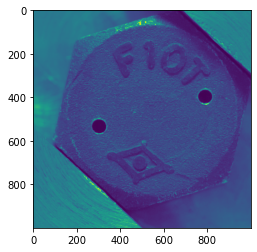

In [ ]:
topic = T.ToPILImage()
imm1 = topic(images[0])
plt.imshow(imm1)

# Defin network

In [ ]:
# todo Bottleneck
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity     # 残差连接
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes):
        super(ResNet, self).__init__()
        self.in_channel = 1    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.fc2 = nn.Linear(in_features=1024, out_features=512) #in=1024, out=512
        self.fc3 = nn.Linear(in_features=512, out_features=128) #in=512, out=128
        self.fc4 = nn.Linear(in_features=128, out_features=num_classes) #in=512, out=1

        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
def testAccuracy():

    net.eval()
    accuracy = 0.0
    total = 0.0
    error = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            predicted, _ = torch.max(outputs.data, 1)
            error += abs(predicted - labels)/labels
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    error = (100* error / total)
    error = np.round(error[0][0].data.cpu().numpy(),2)
    return(error)

def train(num_epochs,device):
    import time
    start_time = time.process_time()
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    accall=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            #print('Prediction data is:',prediction.data.cpu().numpy()[0])
            #print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)
            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 10 == 0:
                # print every 1000 (twice per epoch)
                #print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                print(prediction.data.cpu().numpy()[0],"and",labels.data.cpu().numpy()[0])
                mseloss.append(running_loss/10)
                trainnum.append((i+1)*(epoch+1))
                # zero the loss
                running_loss = 0.0
            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

        accuracy = testAccuracy()
        accall.append(accuracy)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))


    print('Finished Training')

    plt.figure()
    plt.plot()
    plt.grid(True)
    plt.ylim(0,205)
    plt.xlim(0,205)
    plt.plot(train_label.data.numpy(), train_label.data.numpy(), c='Red', lw='3')
    plt.scatter(predata,labeldata)
    plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})


    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylim(0,5)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(trainnum,mseloss)


    end_time = time.process_time()
    print("Use time:", end_time-start_time)


In [ ]:
Vdataiter=iter(valid_loader)#valid_loader
vimg, vlabels = Vdataiter.next()
print(vimg.shape)
print(vlabels.shape)
print(vlabels)

torch.Size([2, 1, 1000, 1000])
torch.Size([2, 1])
tensor([[77.8240],
        [81.7152]])


In [ ]:
def predict(model, device,dataloder):
    Vdataiter=iter(dataloder)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        #_, pre = torch.max(out.data, 1)
        return out, vlabels

# defin model

In [ ]:
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.00025

# 定义模型
#net = Net()
net = ResNet(block=Bottleneck, block_num=[3,4,6,3],num_classes=1)
print(net)
# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = torch.nn.MSELoss()
#loss_func = nn.CrossEntropyLoss() #定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

ResNet(
  (conv1): Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1), 

# main

In [ ]:
 # Vdataiter=iter(valid_loader)
# vimg, vlabels = Vdataiter.next()
# print(vimg.shape)
# print(vlabels.shape)
# print(vlabels)
if __name__ == "__main__":

    torch.cuda.empty_cache()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    # Let's build our model
    train(1000,device)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, 'preloadnet1.pt')

    # Test which classes performed well
    testAccuracy()

    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))

    plt.figure()
    predata, labedata = predict(net, device,valid_loader)#valid
    plt.xlim(0,120)
    plt.ylim(0,120)
    plt.scatter(predata.data.cpu().numpy(),labedata.data.cpu().numpy())
    plt.plot(train_label.data.numpy(), train_label.data.numpy(), c='Red', lw='3')


[1,    10] loss: 1.047
[66.27532] and [64.9216]
[1,    20] loss: 1.552
[26.637756] and [26.624]
[1,    30] loss: 2.989
[68.25023] and [70.2464]
[1,    40] loss: 4.275
[44.9032] and [43.8272]
[1,    50] loss: 8.854
[108.98] and [109.158]
[1,    60] loss: 7.796
[73.27213] and [74.752]
[1,    70] loss: 3.240
[71.423225] and [70.8608]
[1,    80] loss: 5.254
[78.569664] and [76.5952]
[1,    90] loss: 1.331
[97.77483] and [98.5088]
[1,   100] loss: 2.629
[98.011665] and [100.147]
[1,   110] loss: 1.504
[108.83228] and [108.544]
[1,   120] loss: 2.895
[50.143154] and [53.0432]
[1,   130] loss: 1.862
[105.626366] and [105.472]
[1,   140] loss: 2.749
[88.45255] and [87.2448]
For epoch 1 the test accuracy over the whole test set is 22 %
[2,    10] loss: 3.000
[82.611855] and [82.944]
[2,    20] loss: 2.863
[81.82484] and [84.5824]
[2,    30] loss: 3.356
[104.384285] and [105.472]
[2,    40] loss: 2.606
[16.188805] and [19.0464]
[2,    50] loss: 7.721
[34.41908] and [32.9728]
[2,    60] loss: 6.0

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def testAccuracy():

    net.eval()
    accuracy = 0.0
    total = 0.0
    error = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            error += (predicted - labels)/labels
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    error = (100* error / total)
    return(error)

In [ ]:
net.eval()
accuracy = 0.0
total = 0.0
error = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # run the model on the test set to predict labels
        outputs = net(images)
        # the label with the highest energy will be our prediction
        predicted, _ = torch.max(outputs.data, 1)
        error += abs(predicted - labels)/labels
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

# compute the accuracy over all test images
accuracy = (100 * accuracy / total)
error = (100* error / total)
error = np.round(error[0][0].data.cpu().numpy(),2)
print(error)

# Visualization

In [ ]:
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(valid_loader, 0):
    #images, labels = dataiter.next()
    # 输入数据进行预测
    # get the inputs
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    predata = net(images)
    #predata, labedata = predict(net, valid_loader)
    loss=loss_func(predata, labels)
    loss += loss.item()
    x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
    y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
    preloss=loss/(i+1)

x0=x
y0=y

[  0.           1.00840336   2.01680672   3.02521008   4.03361345
   5.04201681   6.05042017   7.05882353   8.06722689   9.07563025
  10.08403361  11.09243697  12.10084034  13.1092437   14.11764706
  15.12605042  16.13445378  17.14285714  18.1512605   19.15966387
  20.16806723  21.17647059  22.18487395  23.19327731  24.20168067
  25.21008403  26.21848739  27.22689076  28.23529412  29.24369748
  30.25210084  31.2605042   32.26890756  33.27731092  34.28571429
  35.29411765  36.30252101  37.31092437  38.31932773  39.32773109
  40.33613445  41.34453782  42.35294118  43.36134454  44.3697479
  45.37815126  46.38655462  47.39495798  48.40336134  49.41176471
  50.42016807  51.42857143  52.43697479  53.44537815  54.45378151
  55.46218487  56.47058824  57.4789916   58.48739496  59.49579832
  60.50420168  61.51260504  62.5210084   63.52941176  64.53781513
  65.54621849  66.55462185  67.56302521  68.57142857  69.57983193
  70.58823529  71.59663866  72.60504202  73.61344538  74.62184874
  75.630252

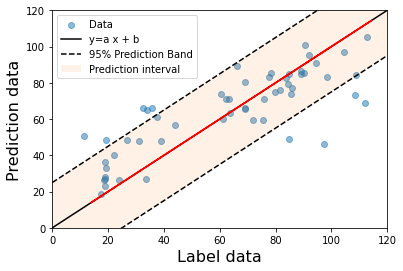

In [ ]:

x=np.linspace(0,120,120)
y=np.linspace(0,120,120)

from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc

plt.figure()

plt.xlim(0,120)
plt.ylim(0,120)
y_err1=1.1*train_label.data.cpu().numpy()
y_err2=0.9*train_label.data.cpu().numpy()
n = len(y)

print(x)


def f(x, a, b):
    return np.multiply(a, x) + b
popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0-(sum((y0-f(x0,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))
print('testdataNum:' + str(i+1))
print('preloss:' + str(preloss))

# plot data

plt.scatter(x0,y0,alpha=0.5, label='Data')

# calculate regression confidence interval
px=np.linspace(0,120,120)
py=a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#plt.fill_between(df['temperature'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=.1, label='Prediction interval')
# prediction band (95% confidence)

# plot the regression
plt.plot(px, nom, c='black', label='y=a x + b')

# # uncertainty lines (95% confidence)
# plt.plot(px, nom - 1.96 * std, c='orange',\
#          label='95% Confidence Region')
# plt.plot(px, nom + 1.96 * std, c='orange')

lpb, upb = predband(px, x0, y0, popt, f, conf=0.95)

lpb=[x+25 for x in px]
upb=[x-25 for x in px]

plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.fill_between(px,lpb,upb, alpha=.1, label='Prediction interval')
plt.plot(train_label.data.numpy(), train_label.data.numpy(), c='Red')

plt.legend(loc='best')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
text='$R^2$: {:.2f}'.format(r2)
#plt.text(180,20,text)
plt.savefig('predictpreload.png', dpi=1200)
plt.show()